# Testing XLuminA: 

(1) *Diffractio vs XLuminA propagation functions.*

(2) *JAX (autodiff-based ADAM) vs SciPy's (BFGS) optimization using XLuminA.*

In [1]:
import time

## (1) Speed test on propagation functions:

    1. Scalar Rayleigh-Sommerfeld (RS)
    2. Scalar Chirped z-transform (CZT)
    3. Vectorial Rayleigh-Sommerfeld (VRS)
    4. Vectorial Chirped z-transform (VCZT)
    
*Test for a computational window size of 2048x2048. You can change the sampling via "resolution".* 

In [2]:
resolution = 2048

### Diffractio: *runs on CPU device*

In [3]:
from diffractio import np, degrees, um, mm
from diffractio.scalar_sources_XY import Scalar_source_XY
from diffractio.vector_sources_XY import Vector_source_XY
from diffractio.scalar_fields_XY import Scalar_field_XY
from diffractio.vector_fields_XY import Vector_field_XY

In [4]:
# System specs:
wavelength = .6328 * um
w0 = (1200*um , 1200*um)
x = np.linspace(-15 * mm, 15 * mm, resolution)
y = np.linspace(-15 * mm, 15 * mm, resolution)
x_out = np.linspace(-15 * mm, 15 * mm, resolution)
y_out = np.linspace(-15 * mm, 15 * mm, resolution)

#### Scalar optics

In [5]:
ls = Scalar_source_XY(x, y, wavelength, info='Light source')
ls.gauss_beam(r0=(0 * um, 0 * um), w0=w0, z0=(0,0), A=1, theta=0 * degrees, phi=0 * degrees)

# Rayleigh-Sommerfeld:
tic = time.perf_counter()
ls_propagated = ls.RS(z=5*mm)
print("Time taken for RS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter()
ls_propagated = ls.CZT(z=5*mm, xout=x_out, yout=y_out, verbose=False)
print("Time taken for CZT propagation - in seconds", time.perf_counter() - tic)

Time taken for RS propagation - in seconds 4.051304008811712
Time taken for CZT propagation - in seconds 1.9945963714271784


#### Vectorial optics

In [6]:
vls = Vector_source_XY(x, y, wavelength=wavelength, info='Light source polarization')
vls.constant_polarization(u=ls, v=(1, 0), has_normalization=False, radius=(15*mm, 15*mm)) 

# Rayleigh-Sommerfeld:
tic = time.perf_counter()
vls.VRS(z=5*mm, n=1, new_field=False, verbose=False, amplification=(1, 1))
print("Time taken for VRS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter()
vls.CZT(z=5*mm, xout=x_out, yout=y_out, verbose=False)
print("Time taken for VCZT propagation - in seconds", time.perf_counter() - tic)

Time taken for VRS propagation - in seconds 12.461026553064585
Time taken for VCZT propagation - in seconds 6.241402745246887


### XLuminA: *runs on CPU and GPU*

*If you are running this notebook in a* **CPU** *node, the software will automatically fall back to CPU. You don't need to change anything :)*

*If you are running this notebook in a* **GPU** *node, you can enable the* **CPU** *via adding these lines of code at the beginning of the cell:*

    import os
    os.environ['CUDA_VISIBLE_DEVICES'] = '[]'
    
*For XLuminA's test we run the functions* **twice** *: the 1st time a function that contains the* **just-in-time decorator** *(@jit) is called, JAX takes extra time to store the function in cache. The second (and subsequent) runs just call the pre-compiled function so the computation is faster.*

In [7]:
from __init__ import mm
from wave_optics import *
from vectorized_optics import *
from optical_elements import *
from loss_functions import *
from toolbox import space
import jax.numpy as jnp

wavelength = .6328 * um
w0 = (1200*um , 1200*um)
x, y = space(15*mm, resolution)
x_out, y_out = jnp.array(space(15*mm, resolution))

#### Scalar optics

In [8]:
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)

# Rayleigh-Sommerfeld:
tic = time.perf_counter() 
ls_propagated = gb.RS_propagation(z=5*mm)
print("Time taken for 1st RS propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
ls_propagated = gb.RS_propagation(z=5*mm)
print("Time taken for 2nd RS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter() 
ls_propagated = gb.CZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 1st CZT propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
ls_propagated = gb.CZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 2nd CZT propagation - in seconds", time.perf_counter() - tic)

Time taken to perform one RS propagation (in seconds): 1.8112342655658722
Time taken for 1st RS propagation - in seconds 1.8123067636042833
Time taken to perform one RS propagation (in seconds): 0.010472599416971207
Time taken for 2nd RS propagation - in seconds 0.010755511000752449
Time taken to perform one CZT propagation (in seconds): 2.7917341720312834
Time taken for 1st CZT propagation - in seconds 2.7920763678848743
Time taken to perform one CZT propagation (in seconds): 0.030082011595368385
Time taken for 2nd CZT propagation - in seconds 0.03025973029434681


#### Vectorial optics

In [9]:
gb_lp = PolarizedLightSource(x, y, wavelength)
gb_lp.gaussian_beam(w0=w0, jones_vector=(1, 0))

# Rayleigh-Sommerfeld:
tic = time.perf_counter() 
gb_propagated = gb_lp.VRS_propagation(z=5*mm)
print("Time taken for 1st VRS propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
gb_propagated = gb_lp.VRS_propagation(z=5*mm)
print("Time taken for 2nd VRS propagation - in seconds", time.perf_counter() - tic)

# Chirped z-transform:
tic = time.perf_counter() 
gb_propagated = gb_lp.VCZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 1st VCZT propagation - in seconds", time.perf_counter() - tic)

tic = time.perf_counter() 
gb_propagated = gb_lp.VCZT(z=5*mm, xout=x_out, yout=y_out)
print("Time taken for 2nd VCZT propagation - in seconds", time.perf_counter() - tic)

Time taken to perform one VRS propagation (in seconds): 1.362658778205514
Time taken for 1st VRS propagation - in seconds 1.3628995660692453
Time taken to perform one VRS propagation (in seconds): 0.14488637447357178
Time taken for 2nd VRS propagation - in seconds 0.14504646696150303
Time taken to perform one VCZT propagation (in seconds): 1.3398055844008923
Time taken for 1st VCZT propagation - in seconds 1.3400872554630041
Time taken to perform one VCZT propagation (in seconds): 0.07045849598944187
Time taken for 2nd VCZT propagation - in seconds 0.07065347023308277


## (2) Comparison of XLuminA's autodiff optimization with SciPy's BFGS optimizer.

*For this test we code an optical setup consisting of a gaussian beam interacting with a spatial light modulator (SLM). The ground truth is a gaussian beam with a spiral phase. The loss function is the mean squared error (MSE) of the phase between the outcome of the setup and the ground truth. Via optimization, we aim to rediscover the phase mask in the SLM device.*

*We optimize using: (1) SciPy's BFGS optimizer (computing the gradients* **numerically** *) and (2) the ADAM optimizer from JAX, which due to autodiff, computes the gradients* **analytically**. *We run the optimization for different* **resolution**.

In [10]:
from __init__ import um, nm, mm, degrees, radians
from wave_optics import *
from optical_elements import SLM
from toolbox import space
import jax.numpy as jnp
import numpy as np

In [11]:
resolution = 10

In [12]:
# System specs
wavelength = 650*nm
x_total = 1000*um 
x, y = space(x_total, resolution)

# Define the incident light: gaussian beam """
w0 = (1200*um , 1200*um)
gb = LightSource(x, y, wavelength)
gb.gaussian_beam(w0=w0, E0=1)

# Ground truth:
gb_gt = ScalarLight(x, y, wavelength)
phase_mask = jnp.arctan2(gb.Y,gb.X)
gb_gt.field = gb.field * jnp.exp(1j * phase_mask)

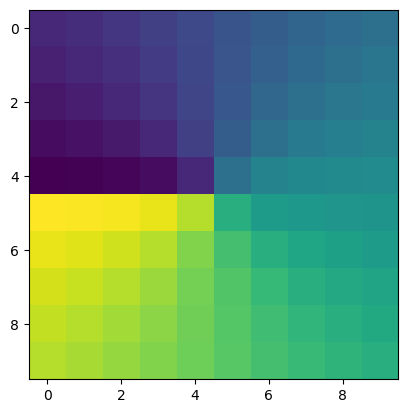

In [13]:
plt.imshow(phase_mask)

### JAX autodiff optimization (with ADAM):

In [14]:
# Setup and loss function: 
def setup(gb, parameters):
    gb_modulated, _ = SLM(gb, parameters, gb.x.shape[0])
    return gb_modulated

def mse_phase(input_light, target_light):
    return jnp.sum((jnp.angle(input_light.field) - jnp.angle(target_light.field)) ** 2) / resolution**2

def loss(parameters):
    out = setup(gb, parameters)
    loss_val = mse_phase(out, gb_gt)
    return loss_val

[gpu(id=0), gpu(id=1)]
Starting Optimization
Stopping criterion: no improvement in loss value for 50 steps
Best loss: 1.7395328971134204e-25 at step 3247; actual step 3300
Time taken to optimize one sample - in seconds 2.607460329309106


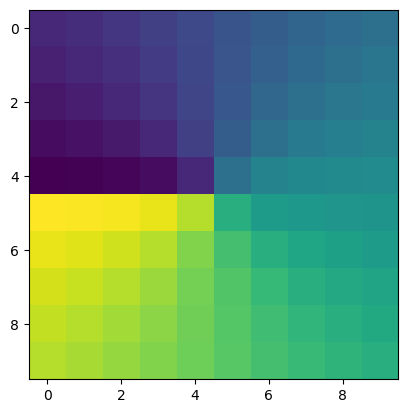

In [15]:
import jax
from jax import grad, jit
from jax.example_libraries import optimizers

# Print device info (GPU or CPU)
print(jax.devices(), flush=True)

# Define the update:
@jit
def update(step_index, optimizer_state):
    # define single update step
    parameters = get_params(optimizer_state)
    # Call the loss function and compute the gradients
    computed_loss = loss_value(parameters)
    computed_gradients = grad(loss_value, allow_int=True)(parameters)

    return opt_update(step_index, computed_gradients, optimizer_state), computed_loss, computed_gradients

# Define the loss function and compute its gradients:
loss_value = jit(loss)

# Optimizer settings
STEP_SIZE = 0.01
num_iterations = 50000
n_best = 50
best_loss = 1e10
best_params = None
best_step = 0

# Init parameters:
init_params = jnp.array([np.random.uniform(-jnp.pi, jnp.pi, (resolution, resolution))], dtype=jnp.float64)
   
# Define the optimizer and initialize it
opt_init, opt_update, get_params = optimizers.adam(STEP_SIZE)
opt_state = opt_init(init_params)

print('Starting Optimization', flush=True)
tic = time.perf_counter()
        
# Optimize in a loop
for step in range(num_iterations):
        
    opt_state, loss_value, gradients = update(step, opt_state)

    if loss_value < best_loss:
        best_loss = loss_value
        best_params = get_params(opt_state)
        best_step = step

    # Stopping criteria:
    if step % 100 == 0:
        if step - best_step > n_best:
            print(f'Stopping criterion: no improvement in loss value for {n_best} steps')
            break

print(f'Best loss: {best_loss} at step {best_step}; actual step {step}')
print("Time taken to optimize one sample - in seconds", time.perf_counter() - tic)

plt.imshow(best_params[0])

### SciPy's optimizer (BFGS):

In [16]:
# Setup (NumPy-based) and loss function: 
def phase(phase):
    return np.exp(1j * phase)

def npSLM(input_field, phase_array, shape):
    slm = np.fromfunction(lambda i, j: phase(phase_array[i, j]),
                           (resolution, resolution), dtype=int)
    light_out = input_field * slm  # Multiplies element-wise
    return light_out, slm

def setup(gb, parameters):
    gb_modulated, _ = npSLM(gb.field, parameters, gb.x.shape[0])
    return gb_modulated

def mse_phase(input_light, target_light):
    return np.sum((np.angle(input_light) - np.angle(target_light.field)) ** 2) / resolution**2

def loss(parameters_flat):
    parameters = parameters_flat.reshape(resolution, resolution)
    out = setup(gb, parameters)
    loss_val = mse_phase(out, gb_gt)
    return loss_val

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 2
         Function evaluations: 505
         Gradient evaluations: 5
Time taken to optimize one sample - in seconds 0.22240092977881432


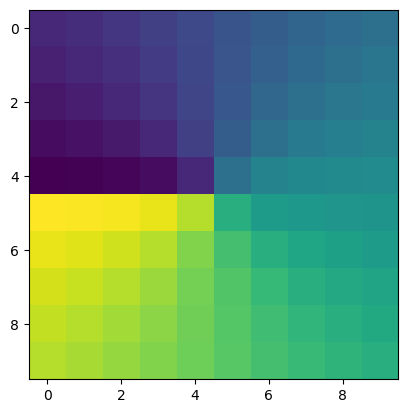

In [17]:
from scipy.optimize import minimize 

# Init parameters
parameters = np.random.uniform(-np.pi, np.pi, (resolution, resolution)).flatten()

# Optimizer
tic = time.perf_counter()
res = minimize(loss, parameters, method='BFGS', options={'disp': True})
print("Time taken to optimize one sample - in seconds", time.perf_counter() - tic)

plt.imshow((res.x).reshape(resolution, resolution))